# Librerias a importar

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import least_squares
from scipy.integrate import quad
from sympy import symbols, diff, exp
from scipy.integrate import solve_ivp

Para abrir en Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/SysBioengLab/IIQ2113-Chemical-reactor-design/blob/main/Ayudantias/ayudantia7.ipynb)

## Definición de funciones
### Es importante destacar que el codigo es complementario al desarrollo de la pregunta 1 de la ayudantía, para comprender que se esta realizando aca es crucial ver la pauta de la ayudantía simultaneamente

In [3]:
def k_eq(k_298,delta_H,T):
    R = 8.314 # J/(mol*K)
    k_T = k_298 * np.exp((-delta_H/R) * (1/T - 1/298))
    return k_T

In [4]:
def X_A_eq(k_eq):
    X_A=k_eq/(1+k_eq)
    return X_A

## P1 a

In [5]:
T_a_evaluar=[333.15,353.15,363.15] ##en K
k_298=255
delta_H=-74900 #en J/mol
X_A_max=[]
for i in range(len(T_a_evaluar)):
    k_T=k_eq(k_298,delta_H,T_a_evaluar[i])
    X_A=X_A_eq(k_T)
    X_A_max.append(X_A)
print("las conversiones maximas a 60, 80 y 90 °C son: ",X_A_max[0],X_A_max[1],X_A_max[2])



las conversiones maximas a 60, 80 y 90 °C son:  0.9130635527531012 0.6942741929272732 0.529393653472157


## P1 b

In [6]:
def k1(T,Ea,A):
    R=8.314 #J/(mol*K)
    k1=A*np.exp(-Ea/(R*T))
    return k1

In [7]:
def objective_function(params, T_exp, k_exp):
    A, Ea=params
    k_predict=[]
    for i in range(len(T_exp)):
        k_predict.append(k1(T_exp[i], Ea, A))
    residuals=[k_predict[i]-k_exp[i] for i in range(len(k_exp))]
    return  np.array(residuals)

In [8]:
def optimize_model_parameters(T_exp, k_exp, params_init):
    bounds=([0,0],[np.inf,np.inf])
    result=least_squares(objective_function, params_init, args=(T_exp,k_exp),bounds=bounds)
    return result.x

In [9]:
k1_exp=[0.0697,0.426,1.78,5.04,12.2]
T_exp=[280,300,320,340,360]  # en K
init_params=[100000000,50000]  #A,Ea
optimized_params=optimize_model_parameters(T_exp,k1_exp,init_params)
print("A y Ea: ",optimized_params)

A y Ea:  [5.59639389e+07 4.59040002e+04]


## Construcción isolineas

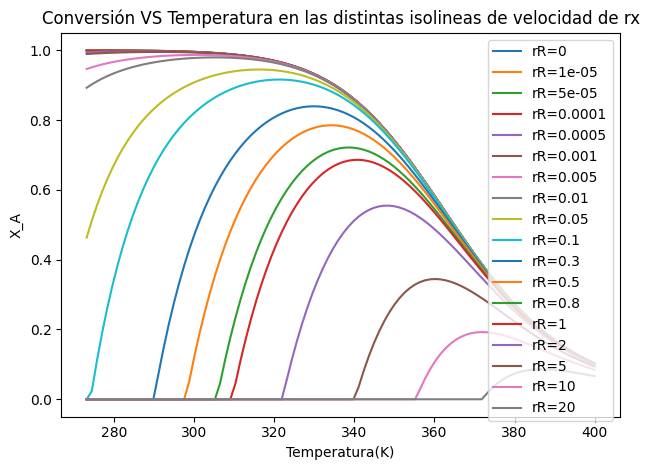

In [10]:
A=optimized_params[0]
Ea=optimized_params[1] #en J/mol
k_298=255
delta_H=-74900  #en J/mol
T_range=np.linspace(273.15,400,100)
rR_to_evaluate=[0,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.3,0.5,0.8,1,2,5,10,20]
X_A_for_each_rR=[]
plt.figure()
for i in range(len(rR_to_evaluate)):
    rR=rR_to_evaluate[i]
    X_A_list=[]
    for j in range(len(T_range)):
        T=T_range[j]
        k_eq_test=k_eq(k_298,delta_H,T)
        X_A_EQ=X_A_eq(k_eq_test)
        k1_test=k1(T,Ea,A)
        X_A_test=X_A_EQ*(1-rR/k1_test)
        X_A=max(0,X_A_test)  ##this is to avoid negative conversion values
        X_A_list.append(X_A)
    X_A_for_each_rR.append(X_A_list)
    plt.plot(T_range,X_A_list,label=f'rR={rR}')
plt.title('Conversión VS Temperatura en las distintas isolineas de velocidad de rx')
plt.xlabel('Temperatura(K)')
plt.ylabel('X_A')
plt.legend()
plt.tight_layout()
plt.show()

        


## P1 c

In [11]:
T=symbols('T') #we define the variable
k_eq1,dH,R=symbols('k_eq1 dH R')  #we define constants
exprs=(k_eq1 * exp((-dH/R)*(1/T-1/298)))/(1+k_eq1 * exp((-dH/R)*(1/T-1/298)))  #we define the expression
print(diff(exprs,T))


-dH*k_eq1**2*exp(-2*dH*(-0.00335570469798658 + 1/T)/R)/(R*T**2*(k_eq1*exp(-dH*(-0.00335570469798658 + 1/T)/R) + 1)**2) + dH*k_eq1*exp(-dH*(-0.00335570469798658 + 1/T)/R)/(R*T**2*(k_eq1*exp(-dH*(-0.00335570469798658 + 1/T)/R) + 1))


In [12]:
def dxa_dT(T,k_298,delta_H):
    R=8.314
    return (delta_H*k_298*np.exp((-delta_H/R)*(1/T-1/298))/(R*T**2*(1+k_298*np.exp((-delta_H/R)*(1/T-1/298)))**2))

In [13]:
def dk1(T,Ea,A):
    R=8.314
    return (A*np.exp(-Ea/(R*T))*Ea/(R*T**2))

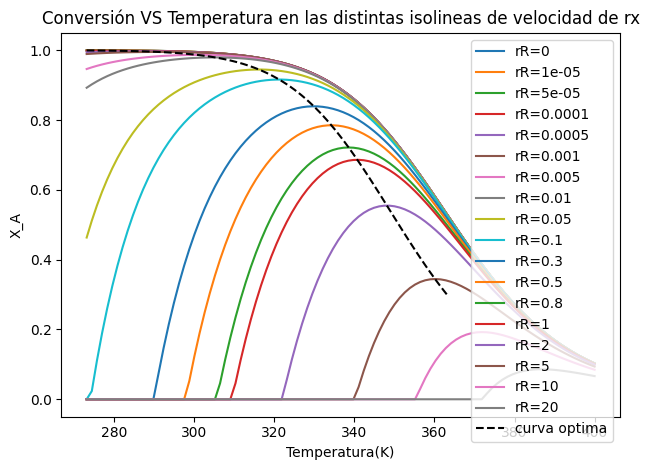

In [14]:
A=optimized_params[0]
Ea=optimized_params[1] #en J/mol
k_298=255
delta_H=-74900  #en J/mol
T_range=np.linspace(273.15,400,100)
plt.figure()
for i in range(len(rR_to_evaluate)):
    rR=rR_to_evaluate[i]
    X_A_list=[]
    for j in range(len(T_range)):
        T=T_range[j]
        k_eq_test=k_eq(k_298,delta_H,T)
        X_A_EQ=X_A_eq(k_eq_test)
        k1_test=k1(T,Ea,A)
        X_A_test=X_A_EQ*(1-rR/k1_test)
        X_A=max(0,X_A_test)  ##this is to avoid negative conversion values
        X_A_list.append(X_A)
    X_A_for_each_rR.append(X_A_list)
    plt.plot(T_range,X_A_list,label=f'rR={rR}')
optimum_curve=[]
optm_T=np.linspace(273.15,363.15,100)
for k in range(len(optm_T)):
    T=optm_T[k]
    k_eq_test=k_eq(k_298,delta_H,T)
    X_A_EQ=X_A_eq(k_eq_test)
    k1_test=k1(T,Ea,A)
    dxa_dt=dxa_dT(T,k_298,delta_H)
    dk1_dt=dk1(T,Ea,A)
    X_A=X_A_EQ*(1-dxa_dt/(dxa_dt-dk1_dt*(X_A_EQ/k1_test)))
    optimum_curve.append(X_A)
plt.plot(optm_T,optimum_curve,'k--',label='curva optima')    
plt.title('Conversión VS Temperatura en las distintas isolineas de velocidad de rx')
plt.xlabel('Temperatura(K)')
plt.ylabel('X_A')
plt.legend()
plt.tight_layout()
plt.show()

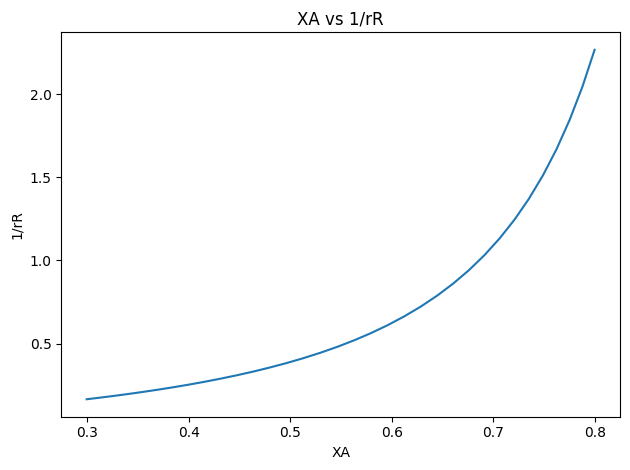

In [15]:
optm_T=np.linspace(363.15,273.15,100)
rR_eval=[]
X_A_finally=[]
for i in range(len(optm_T)):
    T=optm_T[i]
    k_eq_test=k_eq(k_298,delta_H,T)
    X_A_EQ=X_A_eq(k_eq_test)
    k1_test=k1(T,Ea,A)
    dxa_dt=dxa_dT(T,k_298,delta_H)
    dk1_dt=dk1(T,Ea,A)
    X_A=X_A_EQ*(1-dxa_dt/(dxa_dt-dk1_dt*(X_A_EQ/k1_test)))
    if X_A>0.8:
        break
    rR=dxa_dt/((dxa_dt/k1_test)-(X_A_EQ/k1_test**2*dk1_dt))
    rR_eval.append(1/rR)
    X_A_finally.append(X_A)
plt.figure()
plt.plot(X_A_finally,rR_eval)
plt.title('XA vs 1/rR')
plt.xlabel('XA')
plt.ylabel('1/rR')
plt.tight_layout()
plt.show()


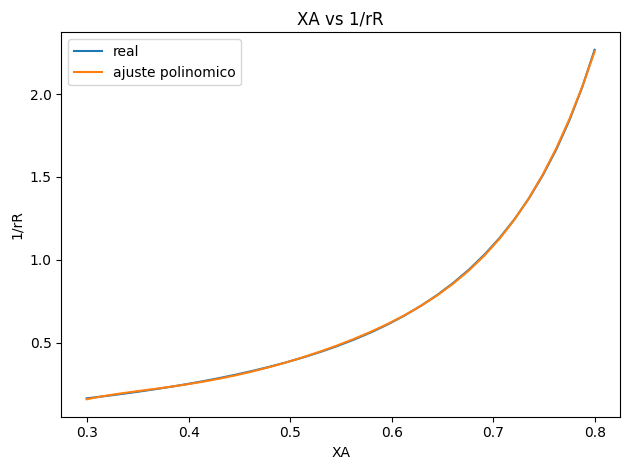

In [16]:
##ahora encontramos un ajuste polinomial para la curva optima
coefficients=np.polyfit(X_A_finally,rR_eval,5)
poly=np.poly1d(coefficients)
##revisamos si este ajuste es bueno para el sistema
plt.figure()
plt.plot(X_A_finally,rR_eval,label='real')
plt.plot(X_A_finally,poly(X_A_finally),label='ajuste polinomico')
plt.title('XA vs 1/rR')
plt.xlabel('XA')
plt.ylabel('1/rR')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
##Viendo que el ajuste es bueno, calculamos la integral
integral_aprox=quad(poly, 0.3, 0.8)
print('la integral aproximada es: ', integral_aprox[0])

la integral aproximada es:  0.34201999850944864


## P2

In [18]:
##constantes del problema
F_Ao = 5        # mol/s
C_Ao = 1        # mol/L
delta_Hrx = -33472   # J/mol
U_a = 5000        
T_a =700        # K (coolant)
Cp =122          # J/(mol*K)

In [19]:
def k1(T):
    return 10**3*np.exp(-4800/(8.31*T))

In [20]:
def sistema_EDOs(V,y):
    X_A,T=y
    ra=k1(T)*C_Ao*(1-X_A)   ##en verdad aqui se calcula -rA
    dXA_dV=ra/F_Ao    
    dT_dV=( ra * (-delta_Hrx) - U_a * (T - T_a) ) / (F_Ao * Cp)
    return [dXA_dV,dT_dV]


In [25]:
yo=[0,500]
V_eval=[0,10]
sol = solve_ivp(sistema_EDOs, V_eval, y0=yo, method='RK45', max_step=0.1)
print('final conversion: ',sol.y[0,-1])
print('exit temperature: ',sol.y[1,-1])


final conversion:  0.9997241178633794
exit temperature:  699.9161668054821
